# Dealing with Images (Enhancing and Segmenting)

## Introduction

This project dives into Encoders-Decoders, where these models are used to edit and generate full images. How these models can be adapted for a wider range of applications such as image denoising or object and instance segmentation. The project will also introduce new concepts like Unpooling, Transposed and Atrous Convolutions layers to the network architecture and its utility for high-dimensional data. Encoders-Decoders can be used for semantic segmentation for driverless cars, where it would help in defining the objects surrounding the vehicle like, roads, other vehicles, people or trees etc. 

## Breakdown of this Project:
- Introduction to Encoders-Decoders. (Notebook 1)
- Encoders-Decoders trained for pixel-level prediction. (Notebook 1)
- Layers such as Unpooling, Transposed and Atrous Convolutions to output high-dimensional data. (Notebook 2)
- FCN and U-Net Architectures for semantic segmentation. (Notebook 3)
- Instance segmentation (extension of Faster-RCNN with Mask-RCNN) (Notebook 4)

## Requirements:
1) Tensorflow 2.0 (GPU prefferably) \
2) CV2 (OpenCV) \
3) Cython \
4) Eigen \
5) PyDenseCRF

For "PyDenseCRF" for windows, LINK: https://github.com/lucasb-eyer/pydensecrf\

It can be installed directly with the following in command prompt or terminal-equivalent: __conda install -c conda-forge pydensecrf__.

If Conda-Forge __does not work__, try: 
- going to: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pydensecrf
- Download: pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl
- Where "cp37" in the filename is the python version of 3.7, make sure you download the correct one.
- Place the downloaded "pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl" file in your working directory drive.
- Open Command Prompt and type in: pip install pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl
- Or if you placed it in a folder or different location: pip install <FILEPATH>\pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl

## Dataset:
    
The dataset can be obtain from the link: http://yann.lecun.com/exdb/mnist/

The MNIST Digits dataset contains 70,000 greyscale images that have 28 x 28 pixels for each of the image. This dataset has been a reference set over the last few years to test and improve methods for this recognition task. The Input vector for the network works out to be 28 x 28 = 784 values and it has an output of 10 values (where there are 10 different digits ranging from 0 to 9). Further, the number of hidden layers for this network will be up to the modeller.


### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import math
import timeit
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2

In [2]:
import os
# from IPython.display import display, Image
import matplotlib.pyplot as plt

# %matplotlib inline

# Set up the working directory for the images:
image_folderName = 'Description Images'
image_path = os.path.abspath(image_folderName) + '/'

In [3]:
# Set the random set seed number: for reproducibility.
Seed_nb = 42

# Set to run or not run the code block: for code examples only. (0 = run code, and 1 = dont run code)
dont_run = 0

### GPU Information:

In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
devices = sess.list_devices()
devices

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5



[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 4423365746621655970),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 6586313605, 8584667623568942693)]

### Use RTX_GPU Tensor Cores for faster compute: FOR TENSORFLOW ONLY

Automatic Mixed Precision Training in TF. Requires NVIDIA DOCKER of TensorFlow.

Sources:
- https://developer.nvidia.com/automatic-mixed-precision
- https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#framework

When enabled, automatic mixed precision will do two things:

- Insert the appropriate cast operations into your TensorFlow graph to use float16 execution and storage where appropriate(this enables the use of Tensor Cores along with memory storage and bandwidth savings). 
- Turn on automatic loss scaling inside the training Optimizer object.

In [5]:
# os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

EXAMPLE CODE: 

In [6]:
# # Graph-based example:
# opt = tf.train.AdamOptimizer()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# train_op = opt.miminize(loss)

# # Keras-based example:
# opt = tf.keras.optimizers.Adam()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# model.compile(loss=loss, optimizer=opt)
# model.fit(...)

### Use RTX_GPU Tensor Cores for faster compute: FOR KERAS API

Source:
- https://www.tensorflow.org/guide/keras/mixed_precision
- https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/experimental/Policy

In [7]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [8]:
# # Set for MIXED PRECISION:
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

### To run this notebook without errors, the GPU will have to be set accordingly:

In [9]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1 - Introduction to Encoders-Decoders:

The Encoder-Decoder architecture is composed of, like its name suggests, an encoder at one half and a decoder at ther other half. The Encoder is essentially a function that will map the input data into a latent space. This latent space is composed of a structured set of values that is defined by the encoder. The Decoder takes the mapped elements from the latent space and maps them into the predefined target domain. Typically, there are many applications for Ecoders-Decoders, such as communications (transmiters and receivers), electronics, and so on. It largely serves the purpose as an information converter. For the purposes of Machine Learning, these kinds of network were used for text translation, whereby the Encoder network would ingest a source language input (like spanish) and learns to project the data into a latent space and have the language's meaning encoded as a feature vector (a.k.a codes), this is then followed by the Decoder network (trained alongside the Encoder) that would convert these encoded feautre vectors into the target language (like english).

Below shows an example of the Ecoder-Decoder Network:

<img src="Description Images/EncoderDecoderNetwork.png" width="750">

Image Ref -> https://www.pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/ and https://www.researchgate.net/figure/t-SNE-visualizations-for-clustering-on-MNIST-dataset-in-a-Original-pixel-space-b_fig1_322674846

Here, the Encoder can be seen to be trained on the MNIST Digits dataset, where it converts the 28x28 images into the latent space of vectors (codes) of 32 values. The Decoder is then trained to recover the images from the latent space of vectors. By plotting (using the t-SNE method) the codes with the class labels, it can be seen that it shows the similarities or its structure inherent of the dataset. These are the semantic information that was referred to earlier. Encoders serves to extract these semantic information that are inherent within the dataset and then it is decoded (by the Decoder) to decompress the information accordingly.

## 2 - Auto-Encoding:

These Auto-Encoders are a special kind of Encoder-Decoder, where for such a task that the input and target domains presents to be the same, like images, the Auto-Encoder should properly encode and decode these images without having any impact on the quality. It should perform all of these despite its inherent bottleneck in desgin. Overall, the process begins with the inputs being converted into a compressed representation into the latent space by the Encoder network, where these feature vectors (compressed representations) will be reconstructed by the Decoder network. The distance between the input and output data is usually the loss calculation that would be minimised. The training process for Auto-Encoders are simpler than others largely due to no requirements for ground truth labels, this is because the input images themselves are used as the ground truth. These kinds of model are typically called __Self-Supervised Models__.

One good example of this is JPEG tools and that these are also AutoEncoders. Similar to the mentioned function above, these JPEG tools will encode the images firstly then proceeds to decode them while retaining as much quality as possible. For images, the loss computation is the distance as cross-entropy loss or L1 (Manhattan) or L2 (Euclidean) loss between the input and the target images.

## 2.1 - Usage of Auto-Encoders:

List of Auto-Encoder usage:

1) __Depth Regression__: It can be used to estimate the distance between the camera and the image content of interests at a pixel level. These kinds are important operations for applications such as Augmented-Reality, which allows for the construction of 3D representation of the surroundings and its interactions with the environment.

2) __Semantic Segmentation__: This is one of the more common use cases, where the model will be trained to return the estimated class for each of the pixels in the iamge. This is a highly important example as it can be used to define objects of interests such as trees, people, vehicles and so on for driverless cars.

3) __Artistic Tasks__: These kinds of Encoder-Decoders can be used for transforming images into pseudo-realistic output images, like estimating objects under the sea without the blue colour of the sea water, or estimating the day time representation of a scene with photos taken at night.

4) __Generative Tasks__: AutoEncoders can also be structurally configured for generative tasks, where the latent space can be structured in such a way during training that when the feature vector is selected it can be decoded to form a picture. This will lead to more advanced models like Generative Adversarial Networks (GANS).

5) __Denoising AEs__: These types of AutoEncoders can transform lossy inputs to return the original versions. Since the input is lossy, the models will then be trained to cancel the lossy operation in order to recover the missing information that will ouptut the original images. The applications for these networks will be for upscaling or super-resolution of images, where it has the added benefits of removing artifacts that are traditionally caused by bilinear interpolation.

## 2.2 - Image Denoising Example:

This section will demonstrate the ease of constructing an example of Encoder-Decoder network with Keras. The architecture here is a symmetrical form of the Encoders-Decoders with the lower dimensional bottlenecks. Both the inputs and targets are set as "x_train". The Sigmoid function is also used in the last layer to output values between 0 and 1.

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

In [11]:
if dont_run == 1:
    
    # Example Code of Encoder-Decoder:
    inputs = Input( shape = [img_height * img_width] )
    
    # Encoder layers:
    encoder_1 = Dense(units = 128, activation = 'relu')(inputs)
    code = Dense(units = 64, activation = 'reult')(encoder_1)
    
    # Decoder Layers:
    decoder_1 = Dense(units = 64, activation = 'relu')(code)
    preds = Dense(units = 128, activation = 'sigmoid')(decoder_1)
    
    # Model:
    autoEncoder = Model(inputs, preds)
    
    # Training phase: notice, the x_train are both input and targets.
    autoEncoder.compile(loss = 'binary_crossentropy')
    autoEncoder.fit(x_train, x_train)

For the purposes of denoising an image, the model above can be trained by passsing in a noisy copy of the training images through the network.

In [12]:
if dont_run == 1:
    # Noisy input images:
    x_noisy = x_train + np.random.normal(loc = .0,
                                         scale = .5,
                                         size = x_train.shape)

    # Fit the model:
    autoEncoder.fit(x_noisy, x_train)

## 3 - Building a Fully Connected Encoder-Decoder:

This section will explore the process of building a Fully Connected Encoder-Decoder network that will be applied to the MNIST Digits dataset. 

### 3.1 - Defining the Hyper-Parameters:

In [13]:
batch_size = 512
nb_epochs = 100

### 3.2 - Load in Dataset: MNIST Digits

In [14]:
# Import the required libraries:
import tensorflow_datasets as tfds

In [15]:
# Load in the Dataset:

# Instantiate the dataset builder:
mnist_builder = tfds.builder("mnist")

# Download and load in the dataset:
mnist_builder.download_and_prepare()

# Check out the dataset information to confirm:
mnist_info = mnist_builder.info
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



### 3.3 - Dataset Pre-processing:

This section will perform transformations to the original downloaded dataset where it will resize the images to the correct dimensions, split and shuffle them.

In [16]:
# Import the required library:
import functools

In [17]:
def _prepare_data_func(features, target = 'label', flatten = True, return_batch_as_tuple = True, seed = None):
    """ This builds a function that will resize the images to the expected dimensions, 
        with the added option to apply random transformations. 
    Parameters:
        - features, is the input data (Images, or others).
        - target, is the Ground Truth or Target data to be returned with the images. 
            (set as 'label' for categorical labels, 'images' for images, otherwise it will be 'None')
        - flatten, is the Flag to flatten the images into a 1D array (28, 28, 1) to (784, ).
        - return_batch_as_tuple, is the Flag to return the batch data as a Tuple rather than Dict.
        - seed, is the seed number to be set for reproducibility.
    Returns:
        - returns the processed dataset.
        
    NOTE: 
        - Tensorflow-Dataset returns batches as feature dictionaries, that are expected for Estimators.
        - To train for Keras Models, it is better to return the batch data as Tuples.
    """
    
    # Select the images:
    image = features['image']
    
    # Convert the images to float type, and scale them from [0, 255] value to [0., 1.] values:
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # If Flag for Flatten is set to True, perform the resizing of the images:
    if flatten:
        is_batched = len(image.shape) > 3
        flattened_shape = (-1, 784) if is_batched else (784, )
        image = tf.reshape(image, flattened_shape)
        
    # 
    if target is None:
        return image if return_batch_as_tuple else {'image': image}
    else:
        features['image'] = image
        return (image, features[target]) if return_batch_as_tuple else features
    

In [18]:
def get_mnist_dataset(phase = 'train', target = 'label', batch_size = 32, nb_epochs = None, shuffle = True, flatten = True, return_batch_as_tuple = True, seed = None):
    """ This builds a function to process and get the dataset. Dataset is from MNIST Digits.
     Parameters:
         - phase, is the current phase of data processing, either 'train' or 'test'.
         - target, is the Ground Truth or Target data to be returned with the images. 
            (set as 'label' for categorical labels, 'images' for images, otherwise it will be 'None')
         - batch_size, is the batch_size.
         - nb_epochs, is the number of epochs.
         - shuffle, is a FLag to shuffle the dataset (default=True).
         - flatten, is the Flag to flatten the images into a 1D array (28, 28, 1) to (784, ).
         - return_batch_as_tuple, is a Flag to return the batched data as a tuple rather than a dict.
         - seed, is the seed number for random operations, allows for reproducibility.
    :return:
        - returns an Iterable Dataset.
    """
    #
    assert(phase == 'train' or phase == 'test')
    
    # Instantiate the data preparation function:
    prepare_data_func = functools.partial(_prepare_data_func, 
                                          return_batch_as_tuple = return_batch_as_tuple,
                                          target = target,
                                          flatten = flatten,
                                          seed = seed)
    
    mnist_data = mnist_builder.as_dataset(split=tfds.Split.TRAIN if phase == 'train' else tfds.Split.TEST)
    mnist_data = mnist_data.repeat(nb_epochs)
    
    # Data Shuffling:
    if shuffle:
        mnist_data = mnist_data.shuffle(10000, seed = seed)
    
    # Split the dataset into batched images:
    mnist_data = mnist_data.batch(batch_size)
    
    # Apply the data prep func to the dataset:
    mnist_data = mnist_data.map(prepare_data_func, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    # Set to prefetch the data: for improved performance.
    mnist_data = mnist_data.prefetch(1)
    
    return mnist_data
    

Apply the above defined functions to the dataset:

In [19]:
# Define the number of classes in this dataset:
nb_classes = mnist_info.features['label'].num_classes

# Define the number of images in this dataset:
nb_train_imgs = mnist_info.splits['train'].num_examples
nb_val_imgs = mnist_info.splits['test'].num_examples

# Define the trainig and validation steps per epoch:
train_steps_per_epoch = math.ceil(nb_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(nb_val_imgs / batch_size)

# Apply the above functions to obtain the processed dataset:
train_mnist_dataset = get_mnist_dataset(phase='train',
                                        target='image',
                                        batch_size=batch_size,
                                        nb_epochs=nb_epochs,
                                        shuffle=True,
                                        flatten=True,
                                        return_batch_as_tuple=True,
                                        seed=Seed_nb)

val_mnist_dataset = get_mnist_dataset(phase='test',
                                      target='image',
                                      batch_size=batch_size,
                                      nb_epochs=1,
                                      shuffle=False,
                                      flatten=True,
                                      return_batch_as_tuple=True,
                                      seed=Seed_nb)

# Define the input shape of the images:
input_shape = mnist_info.features['image'].shape

# Define the input shape when flattened:
flattened_input_shape = [np.prod(input_shape)]

### 3.4 - Building a Simple Auto-Encoder:

The model will be composed of two parts/modules:

1) Is the __Encoder__ module, where it will convert the input images into codes (or the latent space), these are tensors of lower dimensionality. \
2) Is the __Decode__ module, wher it will take the codes as the input and will try to recover and rebuild the original images.

#### Defining the size of the Latent Space or Codes layer:

Here the codes layer wwill be defined as a 32-dimensional vectors. Comparing this to the input vectors, MNIST images are 28 x 28 -> 784-dimensional vectors.

In [20]:
code_size = 32

The model will be constructed with __3 Dense Layers for the Encoder__, then in the subsequent layers, the layers will be decreased slowly down to the dimensionality of the __Code Size__. Once reaching the Codes layer, the __Decoder__ layers will be upsampled back to the __Original Dimensions__ once again.

In [21]:
# Import the required Libraries:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

In [22]:
# Design the AutoEncoder model:

inputs = Input(shape= flattened_input_shape,
               name = 'input')

# Encoder - encoding layers:
encoder_1 = Dense(units=128, activation='relu', name = 'enc_dense1')(inputs)
encoder_2 = Dense(units=64, activation='relu', name = 'enc_dense2')(encoder_1)

# Code Layer:
code = Dense(units=code_size, activation='relu', name = 'enc_dense3')(encoder_2)

# Decoder - decoding layers:
decoder_1 = Dense(units=64, activation='relu', name = 'dec_dense1')(code)
decoder_2 = Dense(units=128, activation='relu', name = 'dec_dense2')(decoder_1)
decoded = Dense(units = flattened_input_shape[0], activation='sigmoid', name = 'dec_dense3')(decoder_2)

# Instantiate the AutoEncoder Model:
autoEncoder = Model(inputs, decoded)
autoEncoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320      
_________________________________________________________________
dec_dense3 (Dense)           (None, 784)               101136

#### The above represents the complete model of the Auto-Encoder based on the meantioned that the Encoder and Decoder layers will be trained together. 

__However__, it is more convenient to split the modules apart, where each would be defined as a separate model with each having their respective layers being wrapped.

#### For the Encoder, the layers from the input to the code layer will be wrapped into a model, seen with the following:

This Encoder model will take in images as its inputs and return the codes for storing.

In [23]:
# Define the wrapped encoder model:
encoder = Model(inputs, code)

# Model summary:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


#### For the Decoder, the model will be composed of the decoding layers of the AutoEncoder defined above, where it would take in the __input codes__ (from the encoder) and then proceeds to return the output images.

There is a problem here, that is the AutoEncoder model's decoding layers are linked to the encoding layers, this will be decoupled and it will instead be connected to a __new__ "Input". This Input will represent the "codes" from the encoder model. To do this, there is a need to detch the decoding layers and then build a new graph based on them.

In [24]:
# Define the NEW Input: code layer.
input_code = Input(shape = (code_size,), 
                   name = 'input_code')

# Rebuild a New Decoder that is based off the AutoEncoder's decoding layers:

# Count the number of decoding layers: Should be 3 in this case.
nb_decoder_layer = 0

for layer in autoEncoder.layers:
    if 'dec_dense' in layer.name:
        nb_decoder_layer += 1

# Apply each layer to the new data to construct a new graph:
dec_i = input_code

# Loop to iterate from the 2 to 0:
for i in range(nb_decoder_layer, 0, -1):
    # Get the decoder layers from the AutoEncoder model, one at a time:
    decoder_layer = autoEncoder.layers[-i]
    
    # Construct the new graph, with same parameters:
    dec_i = decoder_layer(dec_i)
    
# Instantiate the Decoder model based on the newly graphed layers:
decoder = Model(input_code, dec_i)

# Model summary:
decoder.summary()       


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_code (InputLayer)      [(None, 32)]              0         
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320      
_________________________________________________________________
dec_dense3 (Dense)           (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


### 3.5 - Training and Monitoring the Model:

Before the training process can take place, it is essential to create some tools for the purpose of monitoring the training and validation process.

#### 3.5.1 - Peak signal-to-noise ratio (PSNR):

PSNR can be used to determine how well the AutoEncoder performs when recovering the original images. It is described as the ratio between the maximum possible power that an image and the corrupting noise that contributes to the overall quality of the image representation. In other words, it measures the quality that an image is corrupted (or a recovered image) when compared to the original image. To estimate PSNR, a comparison between the ideal image and the computed image.

NOTE: Tensorflow also have its own implementation: tf.image.psnr(a, b, max_val)

Below shows the equation for computing the PSNR:

<img src="Description Images/PSNR.PNG" width="450">

Image Ref -> https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/

Where here,
- O, is the matrix data of the original iamge.
- D, is the matrix of the degraded image.
- m, is hte number of rows of pixels.
- i is the index of the row of image.
- n is the number of columns of pixels.
- j is the index of that column of the image.

__The greater the value of the PSNR, means that it is closer to the original image.__

Source:
- https://www.mathworks.com/help/vision/ref/psnr.html

In [25]:
def log_n(x, n=10):
    """ This builds the function to comput Log to the base of N.
        (i.e. the log base `n` value of `x`).
    Parameters:
        - x, is the Input tensor.
        - n, is the value of the log base.
    Returns:
        - returns, the log result.
    """
    log_e = tf.math.log(x)
    div_log_n = tf.math.log(tf.constant(n, dtype=log_e.dtype))
    
    return log_e / div_log_n

def PSNR(original, compressed, max_pixel = 255.0): 
    """ This builds the PSNR function. It computes the PSNR between two images.
    Parameters:
        - original, is the ideal image or Image A.
        - compressed is the 
    Returns:
        -
    """
    # Compute the MSE:
    mse = tf.reduce_mean( (original - compressed) ** 2 ) 
    
    # Compute the PSNR
    psnr = 20 * log_n(max_pixel, n = 10) - 10 * log_n(mse, n = 10)
    
    return psnr 

Next, is ti apply the above PSNR function by __wrapping it to fit the Keras Interface__ for metrics:

In [26]:
psnr_metrics = functools.partial(PSNR, max_pixel = 1.)

# Set up the name:
psnr_metrics.__name__ = 'psnr'

#### 3.5.2 - Create the Custom Callbacks for monitoring the training process:

This section will create a __Custom Callback Class__ that will inherit the abstract "Callback" class from keras. This class is an interface that will be composed of several methods, that can be called by Keras while training the model (such as before each epoch, before each batch iteration, after each batch iteration and so on).

Here, the implementation will be a callback for plotting the __training loss/metrics__ and __figure updates__ after each epoch:

In [27]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

# " %matplotlib notebook " is used to plot a javascript plots inside of this notebook.


class CustomCallback_DynamicPlotting(tf.keras.callbacks.Callback):
    """ This class is an interface that will be composed of several methods, 
        that can be called by Keras while training the model 
        (such as before each epoch, before each batch iteration, 
        after each batch iteration and so on).
    """
    def on_train_begin(self, logs = {}):
        """ This method is called when training phase starts.
            Used to initialise elements for the Callback method.
        """
        self.logs = dict()
        self.fig, self.ax = None, None
        
    def on_epoch_end(self, epoch, logs = {}):
        """ This method is called after each epoch.
            Keras will call this function and it will provide current epoch number and the
            computed values of the various losses or metrics for this current epoch. ('logs' dict)
        """
        # Adding new log values to the list:
        for key, val in logs.items():
            if key not in self.logs:
                self.logs[key] = []
                
            self.logs[key].append(val)
            
        # Plot all:
        self._plot_logs()
        
    def on_train_end(self, logs = {}):
        """ Set this callback will do nothing at the end of training.
        """
        pass
    
    def on_epoch_begin(self, epoch, logs = {}):
        """ Set this callback will do nothing at the beginning of a new epoch.
        """
        pass
    
    def on_batch_begin(self, batch, logs = {}):
        """ Set this callback will do nothing at the beginning of a new batch.
        """
        pass
    
    def on_batch_end(self, batch, logs = {}):
        """ Set this callback will do nothing at the end of a new batch.
        """
        pass
    
    # Define the logs' plotting func:
    def _plot_logs(self):
        """ This method will clear the figures and redraw over the previous ones 
            with the new values.
        """
        # First call, to initialise the figures:
        if self.fig is None:
            nb_metrics = len(self.logs)
            self.fig, self.ax = plt.subplots(nrows= math.ceil(nb_metrics / 2),
                                             ncols= 2,
                                             figsize = (10, 8)
                                            )
            self.fig.show()
            self.fig.canvas.draw()
            
        # Plotting:
        i = 0        
        for key, val in self.logs.items():
            id_vert, id_hort = i //2, i % 2
            self.ax[id_vert, id_hort].clear()
            self.ax[id_vert, id_hort].set_title(key)
            self.ax[id_vert, id_hort].plot(val)
            i += 1
            
        self.fig.subplots_adjust(right=0.75,
                                 bottom=0.25)
        self.fig.canvas.draw()
        

### 3.6 - Training the model and plot the results of the training and validation:

The training will focus on minimising the __cross-entropy loss__.

In [28]:
# Compile the model:
autoEncoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=[psnr_metrics]
                   )

# running time calculation
start = timeit.default_timer()

D:\anaconda3\envs\Py37Work\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Time: 3.09 Minutes
Time: 0.05 hours


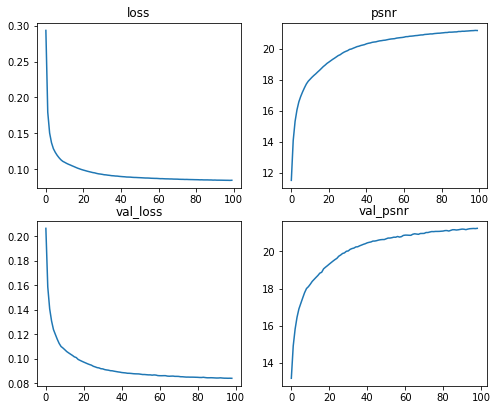

In [29]:
# Train the model:
history = autoEncoder.fit(train_mnist_dataset,
                          epochs= nb_epochs,
                          steps_per_epoch=train_steps_per_epoch,
                          validation_data=val_mnist_dataset,
                          validation_steps=val_steps_per_epoch,
                          verbose = 0,
                          callbacks= [CustomCallback_DynamicPlotting()]
                         )

# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

### Observation:



## 4- Plot the AutoEncoder's Results:

To do this, a method will be built so to output images from the network. This section will also require the package "matplotlib.gridspec".

In [30]:
%matplotlib inline
import matplotlib.gridspec as gridspec

def show_imagePairs(samples_a, samples_b, plot_fn_a="imshow", plot_fn_b="imshow"):
    """ This builds the method to plot the image pairs.
    Parameters:
        - samples_a, is the List of samples A.
        - samples_b, is the List of samples B.
        - plot_fn_a, is the Name of Matplotlib function to plot A (default: "imshow").
        - plot_fn_b, is the Name of Matplotlib function to plot B (default: "imshow")
    Returns:
        - plots the images.
    """
    # Check if the number of samples in both A and B matches:
    assert(len(samples_a) == len(samples_b))
    
    nb_images = len(samples_a)
    
    figure = plt.figure(figsize = (nb_images, 2))
    grid_spec = gridspec.GridSpec(nrows = 1,
                                  ncols = nb_images)
    
    for i in range(nb_images):
        
        grid_spec_i = gridspec.GridSpecFromSubplotSpec(nrows = 2,
                                                       ncols = 1,
                                                       subplot_spec = grid_spec[i],
                                                       hspace=0)
        
        # Draw the image A:
        ax_img = figure.add_subplot(grid_spec_i[0])
        getattr(ax_img, plot_fn_a)(samples_a[i])
        plt.gray()
        ax_img.get_xaxis().set_visible(False)
        ax_img.get_yaxis().set_visible(False)
        
        # Draw the image B:
        ax_img = figure.add_subplot(grid_spec_i[1])
        getattr(ax_img, plot_fn_b)(samples_b[i])
        plt.gray()
        ax_img.get_xaxis().set_visible(False)
        ax_img.get_yaxis().set_visible(False)
    
    # Show the results:
    plt.show()
    

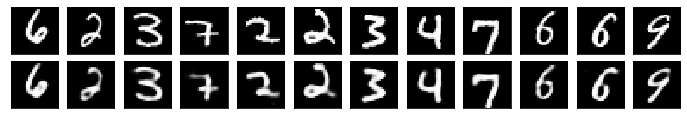

In [37]:
# Set the number of images to show:
nb_show = 12

# Grab the samples from the validation set: set to numpy() for compatibility.
x_test_sample = next(val_mnist_dataset.__iter__())[0][:nb_show].numpy()

# Grab the pedicted results from the model based on the test sample above:
x_decoded = autoEncoder.predict_on_batch(x_test_sample).numpy()

# Plot the image pairs:
show_imagePairs(samples_a = x_test_sample.reshape(nb_show, *input_shape[:2]),
                samples_b = x_decoded.reshape(nb_show, *input_shape[:2])
               )


### Observation:

From the output results, the digits (on the bottom row) can be seen to be a little blurry, however, the recovered digits are still highly readable. The model can be said to be successful at recovering the digits, despite its low dimensional bottleneck and its simple architecture in design.

## 5 - Visualise the AutoEncoder's latent space (codes) and the Dataset Embeddings:

Visualise the codes layer of the images in the latent space. These images are in their corresponding 32-dimensional codes. This can be done as the Encoder layer was instantiated earlier on.

### 5.1 - Code Layer Images visualisation:

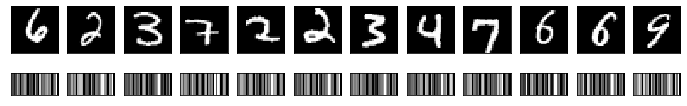

In [38]:
# Grab the output the Encoder -> which is the Codes layer:
x_encoded = encoder.predict_on_batch(x_test_sample)
x_encoded = x_encoded.numpy()

# To ensure that the visualisation is readable, some scaling up is required:
x_encoded_scaled = np.tile( x_encoded.reshape(nb_show, 1, code_size), (1, 15, 1) )


# Visualise:
show_imagePairs(samples_a = x_test_sample.reshape(nb_show, *input_shape[:2]),
                samples_b = x_encoded_scaled,
                plot_fn_b = "matshow"
               )

### Observation:

As it can be seen that the codes layer are several black and white lines and is unique to each digit. In its 32 dimensional form, it is hard to interpret from a human perspective, however, it contains enough information for the decoder to reconstruct the codes back into the original images.

### 5.2 - Visualise the Dataset Embeddings with t-SNE:

To help make the 32 dimensional latent space more understandable from the human perspective, a 2D method of projection is the better approach. There are many types of prjection methods such as PCA, LDA and so on, but here the t-SNE method will be utilised. 

In less detail, it can be simplified as, T-distributed Stochastic Neighbor Embedding (t-SNE) minimises the divergence between two distributions. These two distributions are firstly, a distribution that measures pairwise similarities of the input objects and secondly, a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding (codes). Overall, it maps multi-dimensional data into a lower dimensional space, and to find patterns inherent of the dataset to identify clusters based on similarity of data points wiht multiple features. Note that inference cannot be done or be based on the t-SNE output, as it is mainly for data visualisation. 

In more detail, t-SNE can be described as a non-linear technique used for dimensionality reduction. It is highly suitable for visualisation tasks of high-dimensional datasets, such as the 32 dimensional codes layer output. It computes the probability of similarity of the points in high-dimensional space. The similarity of these points are computed as the confitional probability, that a point A would pick point B to be its neighbour, if the neighbours that were picked in proportion to their probability density under a Gaussian distribution that is centred at A. Next, it will minimise the difference between these confitional probablities (or its similarities) in both higher and lower dimensional space to provide a perfect representation of the data points in a lower-dimensional space. t-SNE will minimise the sum of the Kullback-Leibler (KL) divergrence of the overall data points with gradient descent in order to measure the minimisation of the sum of difference of the coditional probability. KL divergence is a measure of how one probability distribution diverges from another expected probability distribution.

Source: https://www.datacamp.com/community/tutorials/introduction-t-sne

In [50]:
# Import the require library:
from sklearn.manifold import TSNE

In [51]:
# Instantiate a t-SNE object:
tsne = TSNE(n_components=2, verbose=1, random_state=0)

There is a need to firstly __convert the entire dataset__ into codes, so that t-SNE can be applied to them. Next a scatter plot will be used to visualise the patterns.

In [65]:
# Convert Entire dataset:
_, (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scaling the data:
x_test, y_test = x_test / 255.0, y_test / 255.0

# Flatten the data:
x_test = x_test.reshape(x_test.shape[0], *flattened_input_shape)

In [66]:
# Obtain the 2-Dimensional representations with t-SNE:\
x_encoded = encoder.predict_on_batch(x_test)
x_2D = tsne.fit_transform(x_encoded)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.059s...
[t-SNE] Computed neighbors for 10000 samples in 3.932s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.612685
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.079956
[t-SNE] KL divergence after 1000 iterations: 1.807145


#### Plot the 2D t-SNE visualisation:

In [56]:
# Import the require Liibrary:
import matplotlib

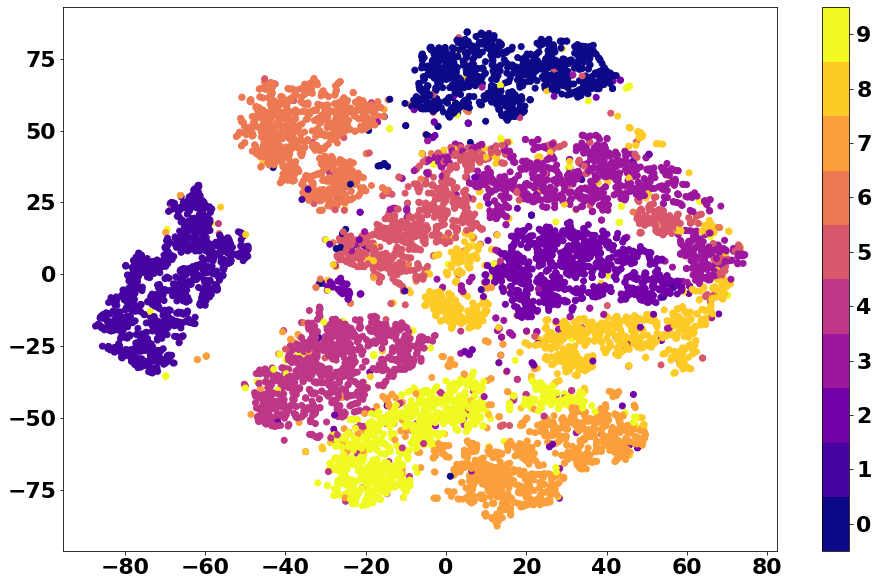

In [61]:
font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}

matplotlib.rc('font', **font)

figure = plt.figure( figsize = (16,10) )

# Plot:
plt.scatter(x = x_2D[:, 0], # x coords for the projections
            y = x_2D[:, 1], # y coords for the projections
            c= y_test, # Per Class Colours
#             cmap= plt.cm.get_cmap("jet", nb_classes)
            cmap= plt.cm.get_cmap("plasma", nb_classes)
           )
plt.colorbar(ticks = range(nb_classes))
plt.clim(vmin=-0.5, vmax=nb_classes - 0.5)
plt.show()

# Conclusion:

The above shows how the AutoEncoder was able to discern similarities and structures that is inherent of the dataset in the codes layer, from these it was able to reconstruct them back to the original images. It was also able to compress the dataset, without losing too much detail, and was then able to reconstruct them. Each of the point represents a digit image, where there are distinguished features that separates each class as seen by the clustering of the data points. 


# Part 2 of this Project

## 6 - Appllication of AutoEncoders in Denoising:

In this part of the project, the aim would be to utilise the Fully Connected Auto-Encoder that was implemented to recover __Noissy Images__. These kinds of images can also be corrupted images.

### 6.1 - Dataset Preparation:

In this section, the dataset will be obtain with Keras (rather than TensorFlow Datasets), so that the dataset will be in Numpy Arrays. This is for compatibility with Keras Utilities.

NOTE: 
- As with Using AutoEncoder, the Class labels and data won't be utilised (y_train, y_test).
- Keras image pre-processing tool will be used later on to add Noise to the data, therefore the augmented images will be flattened by the Network itself under the initial Flatten() layer. Meaning that the data won't be needed to be flattened beforehand manually.

In [83]:
# Load in the Dataset:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Define the Image Specfication:
img_height, img_width = x_train.shape[1:]
img_channels = 1
input_shape = (img_height, img_width, img_channels)

# Normalise the Dataset:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the images (No manual Flattening):
x_train = x_train.reshape( (-1, img_height, img_width, img_channels) )
x_test = x_test.reshape( (-1, img_height, img_width, img_channels) )

print("Shape of training set: {}".format(x_train.shape))
print("Shape of testing set: {}".format(x_test.shape))

Shape of training set: (60000, 28, 28, 1)
Shape of testing set: (10000, 28, 28, 1)


In [84]:
# Setting the training and validation steps per epoch:
train_steps_per_epoch = len(x_train) // batch_size
val_steps_per_epoch = len(x_test) // batch_size


### 6.2 - 

## Summary:

This part of the project (notebook 1) was able to show how the fundamentals of how an Autoencoder is able to recover images from the latent space, and subsequently demonstrate how it can be applied to pixel-level predictions. This project also taught me the implementation of several tools, such as custom metrics and losses computations, callbacks and buidling modular models.

The second part of the project (notebook 1 continued)... to be continued.